# Deploying the Hybrid Test Bench Emulator Service

This notebook consits of 2 sections:
1. Hybrid Test Bench Physical Twin Emulator Service,
2. Rainflow-Counting Algorithm,

where the first section is the majority of it, and the second section is just a short calculation of the RFCA, showing that it works for our case. We didn't go into detail in that section, our focus will be on the Emulator Service.

In the first part we will first deploy a service that emulates the Hybrid Test Bench Physical Twin, and then also the Digital Twin service. Subsequently we will also create a service that stores data into the time series database for each of them, and they will be used for different concepts, such as calibration and monitoring.

# 1. Hybrid Test Bench Physical Twin Emulator Service

The interface of our Emulator follows the example from the IncubatorDTCourse repository. Here we do the following:

1. We make sure that the **environment** is set up correctly and we configure the **logging**.

2. We create the **pt_emulator_service.py**, which produces RabbitMQ messages that contain data that exactly matches the data produced by the real Hybrid Test Bench. Unlike the real Hybrid Test Bench, we will have to code the behavior that corresponds to applying a force on a specific beam. This behaviour will be triggered by sending a RabbitMQ message that the emulator will listen for. This will result in a change in displacement.
   
3. We also create the **dt_service.py**, which isn't an emulation of the Digital Twin, but rather a smaller service, which is then used for collecting data and recalibrating the Physical Twin.

4. We create the **hybrid_test_bench_data_recorder_influx.py**, which deploys a service that subscribes to all relevant messages being exchanged, and stores them in the time series database, so that it can be visualized.

**In the end**, we check that all services are running and we check the data coming to the InfluxDB dashboard. We then send messages, that will affect the behaviour of the emulator and the dt service, and we will be able to see the change in the InfluxDB dashboard.

**To get our service running do the followning:**
1. Make sure you're in the root of our repository ([hybrid-test-bench](./))
2. Run the following command: 

```bash
    python -m startup.start_services
   ``` 

This will start both InfluxDB and RabbitMQ services. This way we can have a consistent environment accross all machines.

Local sites, usernames and passwords are the following:

- **InfluxDB:**
  - Local site: [http://localhost:8086/](http://localhost:8086/)
  - User: bench
  - Password: hybridtestbench

- **RabbitMQ:**
  - Local site: [http://localhost:15672/](http://localhost:15672/)
  - User: bench
  - Password: bench

Now you should be able to access these two services, and we'll continue from here. Let's start the emulation process!

Run the next two code blocks to set up the environment and configure the logging:

In [1]:
%%writefile logging.conf

[loggers]
keys=root,PTModel,DTModel,Actuator,PTEmulatorService,DTService,HybridTestBenchDataRecorderInflux,CalibrationService,RFCA

[handlers]
keys=consoleHandler,PTModelFileHandler,DTModelFileHandler,ActuatorFileHandler,PTEmulatorServiceFileHandler,DTServiceFileHandler,HybridTestBenchDataRecorderInfluxFileHandler,CalibrationServiceFileHandler,RFCAFileHandler

[formatters]
keys=simpleFormatter

[logger_root]
level=DEBUG
handlers=consoleHandler

[logger_PTModel]
level=DEBUG
handlers=PTModelFileHandler
qualname=PTModel
propagate=0

[logger_DTModel]
level=DEBUG
handlers=DTModelFileHandler
qualname=DTModel
propagate=0

[logger_Actuator]
level=DEBUG
handlers=ActuatorFileHandler
qualname=Actuator
propagate=0

[logger_PTEmulatorService]
level=DEBUG
handlers=PTEmulatorServiceFileHandler
qualname=PTEmulatorService
propagate=0

[logger_DTService]
level=DEBUG
handlers=DTServiceFileHandler
qualname=DTService
propagate=0

[logger_HybridTestBenchDataRecorderInflux]
level=DEBUG
handlers=HybridTestBenchDataRecorderInfluxFileHandler
qualname=HybridTestBenchDataRecorderInflux
propagate=0

[logger_CalibrationService]
level=DEBUG
handlers=CalibrationServiceFileHandler
qualname=CalibrationService
propagate=0

[logger_RFCA]
level=DEBUG
handlers=RFCAFileHandler
qualname=RFCA
propagate=0

[handler_consoleHandler]
class=StreamHandler
formatter=simpleFormatter
args=(sys.stdout,)

[handler_PTModelFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('PTModel.log', 'w')

[handler_DTModelFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('DTModel.log', 'w')

[handler_ActuatorFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('Actuator.log', 'w')

[handler_PTEmulatorServiceFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('PTEmulatorService.log', 'w')

[handler_DTServiceFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('DTService.log', 'w')

[handler_HybridTestBenchDataRecorderInfluxFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('HybridTestBenchDataRecorderInflux.log', 'w')

[handler_CalibrationServiceFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('CalibrationService.log', 'w')

[handler_RFCAFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('RFCA.log', 'w')

[formatter_simpleFormatter]
format=%(asctime)s.%(msecs)03d %(levelname)s %(name)s : %(message)s
datefmt=%Y-%m-%d %H:%M:%S

Overwriting logging.conf


In [2]:
import sys
import os

# Get the current working directory. Should be hybrid-test-bench
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

Now that we have set up our environment, we continue by creating the PT_emulator_service script:

In [3]:
%%writefile pt_emulator_service.py

# Configure python path to load hybrid test bench modules
import sys
import os
import logging
import logging.config
import time
import numpy as np
from math import *

from scipy.integrate import solve_ivp

# Get the current working directory. Should be hybrid-test-bench
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_FORCES, ROUTING_KEY_DISPLACEMENT
import pt_model as pt_model
# import dt_model as dt_model
import calibration_service as cal_service
import actuator_controller as ac_ctrl
import RainFlowCycleAlgorithm as rfca

# Define the global variables for the model
fx, fy, fz, mx, my, mz = 1, 2, 3, 4, 5, 6 # force and moment indices

class PTEmulatorService:
    
    def __init__(self, uh_initial, uv_initial, lh_initial, lv_initial, max_vertical_displacement, execution_interval, rabbitmq_config):
        # Initialize the PTEmulatorService with initial values and configuration
        self._l = logging.getLogger("PTEmulatorService")
        self._l.info("Initializing PTEmulatorService.")

        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        
        self.uh = uh_initial
        self.uv = uv_initial
        self.lh = lh_initial
        self.lv = lv_initial

        self.vertical_period = 2.0
        self.horizontal_period = 2.0

        self.lh_wanted = 100
        self.uv_wanted = 20

        self.max_vertical_displacement = max_vertical_displacement
        self._execution_interval = execution_interval # seconds
        self._force_on = 0.0
        self.E_modulus = 70e3 # MPa (example value for aluminum)
        self.Damage = 0.0

        # Initialize the PT model instance
        try:
            self.PT_Model = pt_model.PtModel()
        except Exception as e:
            self._l.error("Failed to initialize PTModel: %s", e, exc_info=True)
            raise

        # Initialize the actuator controller instance
        try:
            self.H_ac = ac_ctrl.ActuatorController(self.lh_wanted, self.horizontal_period, self._execution_interval)
            self.V_ac = ac_ctrl.ActuatorController(self.uv_wanted, self.vertical_period, self._execution_interval)
        except Exception as e:
            self._l.error("Failed to initialize ActuatorController: %s", e, exc_info=True)
            raise

        # Initialize the RFCA (RainFlow Cycle Algorithm) instance (Only in PT)
        try:
            self.RFCA = rfca.RFCA([])
        except Exception as e:
            self._l.error("Failed to initialize RFCA: %s", e, exc_info=True)
            raise

        self.PT_Model.set_beampars(16, 'E', self.E_modulus) # Set the beam parameters for the PT model  

    def setup(self):
        self._rabbitmq.connect_to_server()

        # Declare local queues for the force messages
        self.forces_queue_name = self._rabbitmq.declare_local_queue(routing_key=ROUTING_KEY_FORCES)

        self._l.info(f"PTEmulatorService setup complete.")

    def _read_forces(self):
        # Read the forces from the RabbitMQ queue
        
        msg = self._rabbitmq.get_message(self.forces_queue_name)
        #self._l.debug(f"Message received: {msg}")
        if msg is not None:
            return msg
        else:
            return None
    
    def check_control_commands(self):
        # Check if there are control commands
        force_cmd = self._read_forces()
        # self._l.debug(f"Control command: {force_cmd}")
        if force_cmd is not None:
            if 'forces' in force_cmd and force_cmd['forces'] is not None:
                self._l.info("Force command: %s", force_cmd["forces"])
                self._force_on = 1.0 if force_cmd["forces"] else 0.0

            if "horizontal_force" in force_cmd and force_cmd["horizontal_force"] is not None:
                self._l.info(f"Horizontal force command: {force_cmd['horizontal_force']}")
                self.lh_wanted = force_cmd["horizontal_force"]
                self.H_ac.set_amplitude(self.lh_wanted)

            if "vertical_displacement" in force_cmd and force_cmd["vertical_displacement"] is not None:
                self._l.info(f"Vertical force command: {force_cmd['vertical_displacement']}")
                self.uv_wanted = force_cmd["vertical_displacement"]
                self.V_ac.set_amplitude(self.uv_wanted)
                
            if "horizontal_period" in force_cmd and force_cmd["horizontal_period"] is not None:
                self._l.info(f"Horizontal period command: {force_cmd['horizontal_period']}")
                self.horizontal_period = force_cmd["horizontal_period"]
                self.H_ac.set_period(self.horizontal_period)
                
            if "vertical_period" in force_cmd and force_cmd["vertical_period"] is not None:
                self._l.info(f"Vertical period command: {force_cmd['vertical_period']}")
                self.vertical_period = force_cmd["vertical_period"]
                self.V_ac.set_period(self.vertical_period)

    def emulate_pt(self):
        # Emulate the PT behavior based on the control commands

        # Additional logic for the emulator can go here
        # Additional logic for the PT emulator can go here
        if self._force_on == 1.0:
            try:
                Load = self.H_ac.step_simulation()
                Displacement = self.V_ac.step_simulation()
                self._l.info(f"Load: {Load}, Displacement: {Displacement}")
                self.PT_Model.set_loads_between_nodes(Load, [9,10])
                self.PT_Model.set_displacements_between_nodes(Displacement,[5,10])
            except Exception as e:
                self._l.error("Failed to emulate PT behavior: %s", e, exc_info=True)
                raise

            try:
                self.PT_Model.run_simulation()
            except Exception as e:
                self._l.error("Simulation failed: %s", e, exc_info=True)
                raise
            
            self._uh, self._uv, self._lh, self._lv = self.get_data(10) # Get the data from the PT model (10 is the node number)
            self._l.info(f"Horizontal displacement: {self._uh}, Vertical displacement: {self._uv}, Horizontal force: {self._lh}, Vertical force: {self._lv}")
            
            # Fatigue - PT only
            if self.RFCA.update_if_peak(self._lv):
                self._l.info(f"Running Fatigue test")
                [self.Damage, self.E_modulus] = self.PT_Model.calculate_fatigue(self.RFCA.get_cycles())
                self._l.info(f"Fatigue test result: {round(self.E_modulus)} MPa, Damage: {round(self.Damage,3)}")

        else:
            # Horizontal displacement
            self._uh = 0.0
            # Vertical displacement
            self._uv = 0.0
            # Horizontal force
            self._lh = 0.0
            # Vertical force
            self._lv = 0.0
            # Restoring force
            # self._r = r[something] # in case we need this for the emulator, we can put it here

        self.E_modulus = self.PT_Model.get_beampars(16).E # Get the E modulus from the PT model
        #self._l.info("PT script executed successfully.")
        
    def send_state(self, time_start):
        #self._l.info("Sending state to hybrid test bench physical twin.")
        timestamp = time.time_ns()
        # Publishes the new state
        message = {
            "measurement": "emulator",
            "time": timestamp,
            "tags": {
                "source": "emulator"
            },
            "fields": {
                "horizontal_displacement": self._uh,
                "vertical_displacement": self._uv,
                "horizontal_force": self._lh,
                "vertical_force": self._lv,
                "horizontal_displacement_between": self.PT_Model.get_displacement_between_nodes(9, 10),
                "vertical_displacement_between": self.PT_Model.get_displacement_between_nodes(5, 10),
                "E_modulus": self.E_modulus,
                "force_on": self._force_on,
                "max_vertical_displacement": self.max_vertical_displacement,
                "execution_interval": self._execution_interval,
                "elapsed": time.time() - time_start,
            }
        }
        
        self._rabbitmq.send_message(ROUTING_KEY_STATE, message)

    def update_state(self, time_start):
        #self._l.info("Sending state to hybrid test bench physical twin.")
        timestamp = time.time_ns()
        # Publishes the new state
        state_message = {
            # "pt_displacements": self.PT_Model.get_displacement([10, 10, 10], [1, 2, 3])
            "horizontal_displacement": round(self.PT_Model.get_displacement_between_nodes(9, 10), 3),
            "vertical_displacement": round(self.PT_Model.get_displacement_between_nodes(5, 10), 3),
            "horizontal_force": round(self.PT_Model.get_load(10, fx), 3),
            "vertical_force": round(self.PT_Model.get_load(10, fz), 3)
            }

        self._rabbitmq.send_message(ROUTING_KEY_DISPLACEMENT, state_message)
        #self._l.debug(f"Message sent to {ROUTING_KEY_STATE}.")
        #self._l.debug(message)
    
    def start_emulation(self):
        # Start the emulation loop
        self._l.info("Starting PTEmulator emulation loop.")
        send_state_interval = 1
        try:
            while True:
                #self._l.debug("Emulation loop iteration.")
                time_start = time.time()
                #Check if there are control commands
                self.check_control_commands()
                # Emulate the PT behavior
                self.emulate_pt() 
                # Send the new state to the hybrid test bench physical twin
                self.send_state(time_start)
                if send_state_interval == 3:
                    self.update_state(time_start)
                    send_state_interval = 0
                send_state_interval += 1                 # Sleep until the next sample
                time_end = time.time()
                time_diff = time_end - time_start
                if time_diff < self._execution_interval:
                    time.sleep(self._execution_interval - time_diff)
                else:
                    self._l.warning(f"Emulation loop took too long: {time_diff} seconds.")
        except KeyboardInterrupt:
            self._l.info("Emulation loop interrupted by user.")
        except Exception as e:
            self._l.error("Emulation loop failed: %s", e, exc_info=True)

    def get_data(self, node):
        # Get the data from the PT model
        try:
            uh = float(self.PT_Model.get_displacement(node, fx))
            uv = float(self.PT_Model.get_displacement(node, fz))
            lh = float(self.PT_Model.get_load(node, fx))
            lv = float(self.PT_Model.get_load(node, fz))
            return uh, uv, lh, lv
        except Exception as e:
            self._l.error("Failed to get data from PT model: %s", e, exc_info=True)
            raise
        return self._uh, self._uv, self._lh, self._lv
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory
    
    logging_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'logging.conf')
    logging.config.fileConfig(logging_conf)

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)
    
    service = PTEmulatorService(
        uh_initial = 0.0,
        uv_initial = 0.0,
        lh_initial = 0.0,
        lv_initial = 0.0,
        max_vertical_displacement = 70.0,
        execution_interval = 3.0,
        rabbitmq_config=config["rabbitmq"])

    service.setup()
    
    # Start the PTEmulatorService
    service.start_emulation()

Overwriting pt_emulator_service.py


Next we'll create the DT service script

In [1]:
%%writefile dt_service.py

# Configure python path to load hybrid test bench modules
import sys
import os
import logging
import logging.config
import time
import numpy as np
from math import *

from scipy.integrate import solve_ivp

# Get the current working directory. Should be hybrid-test-bench
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_DT_FORCES, ROUTING_KEY_DISPLACEMENT
import dt_model as dt_model
import pt_model as pt_model
import calibration_service as cal_service
import actuator_controller as ac_ctrl

# Define the global variables for the model
fx, fy, fz, mx, my, mz = 1, 2, 3, 4, 5, 6 # force and moment indices

class DTService:
    
    def __init__(self, uh_initial, uv_initial, lh_initial, lv_initial, max_vertical_displacement, min_e_modulus, execution_interval, rabbitmq_config):
        # Initialize the DTService with initial values and configuration
        self._l = logging.getLogger("DTService")
        self._l.info("Initializing DTService.")

        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        
        self.uh = uh_initial
        self.uv = uv_initial
        self.lh = lh_initial
        self.lv = lv_initial

        self.vertical_period = 2.0
        self.horizontal_period = 2.0

        self.lh_wanted = 100
        self.uv_wanted = 20

        self.max_vertical_displacement = max_vertical_displacement
        self.min_e_modulus = min_e_modulus
        self._execution_interval = execution_interval # seconds
        self._force_on = 0.0
        self.E_modulus = 100e3 # MPa (wrong example value for aluminum)
        # self.Damage = 0.0

        self.PT_Model_h_d = 0.0
        self.PT_Model_v_d = 0.0
        self.PT_Model_h_f = 0.0
        self.PT_Model_v_f = 0.0

        # Initialize the DT model instance
        try:
            self.DT_Model = dt_model.DtModel()
        except Exception as e:
            self._l.error("Failed to initialize DTModel: %s", e, exc_info=True)
            raise

        # Initialize the actuator controller instance
        try:
            self.H_ac = ac_ctrl.ActuatorController(self.lh_wanted, self.horizontal_period, self._execution_interval)
            self.V_ac = ac_ctrl.ActuatorController(self.uv_wanted, self.vertical_period, self._execution_interval)
        except Exception as e:
            self._l.error("Failed to initialize ActuatorController: %s", e, exc_info=True)
            raise

        # Initialize the CalibrationService instance (Only in DT)
        try:
            self.calibration_service = cal_service.CalibrationService(self.DT_Model) # DT Model
        except Exception as e:
            self._l.error("Failed to initialize CalibrationService: %s", e, exc_info=True)
            raise

        self.DT_Model.set_beampars(16, 'E', self.E_modulus) # Set the beam parameters for the DT model 

    def setup(self):
        self._rabbitmq.connect_to_server()

        # Declare local queues for the force messages
        self.forces_queue_name = self._rabbitmq.declare_local_queue(routing_key=ROUTING_KEY_DT_FORCES)
        self.displacements_queue_name = self._rabbitmq.declare_local_queue(routing_key=ROUTING_KEY_DISPLACEMENT)

        self._l.info(f"DTService setup complete.")

    def _read_forces(self):
        # Read the forces from the RabbitMQ queue
        msg = self._rabbitmq.get_message(self.forces_queue_name)

        if msg is not None:
            return msg
        else:
            return None

    def _read_state(self):
        # Read the PT model from the RabbitMQ queue
        msg = self._rabbitmq.get_message(self.displacements_queue_name)

        if msg is not None:
            return msg
        else:
            return None
    
    def _check_pt_model(self):
        # Check if there are control commands
        state = self._read_state()
        #self._l.debug(f"Control command: {pt_model}")
        if state is not None:
            self.state_received = True
            if 'horizontal_displacement' in state and state['horizontal_displacement'] is not None:
                # self._l.info("Horizontal displacement: %s", state["horizontal_displacement"])
                self.PT_Model_h_d = state["horizontal_displacement"]
            if 'vertical_displacement' in state and state['vertical_displacement'] is not None:
                # self._l.info("Vertical displacement: %s", state["vertical_displacement"])
                self.PT_Model_v_d = state["vertical_displacement"]
            if 'horizontal_force' in state and state['horizontal_force'] is not None:
                # self._l.info("Horizontal force: %s", state["horizontal_force"])
                self.PT_Model_h_f = state["horizontal_force"]
            if 'vertical_force' in state and state['vertical_force'] is not None:
                # self._l.info("Vertical force: %s", state["vertical_force"])
                self.PT_Model_v_f = state["vertical_force"]
        else:
            self.state_received = False
            # self._l.debug("No control command received.")
    
    def check_control_commands(self):
        # Check if there are control commands
        force_cmd = self._read_forces()
        #self._l.debug(f"Control command: {force_cmd}")
        if force_cmd is not None:
            if 'forces' in force_cmd and force_cmd['forces'] is not None:
                self._l.info("Force command: %s", force_cmd["forces"])
                self._force_on = 1.0 if force_cmd["forces"] else 0.0

            if "horizontal_force" in force_cmd and force_cmd["horizontal_force"] is not None:
                self._l.info(f"Horizontal force command: {force_cmd['horizontal_force']}")
                self.lh_wanted = force_cmd["horizontal_force"]
                self.H_ac.set_amplitude(self.lh_wanted)

            if "vertical_displacement" in force_cmd and force_cmd["vertical_displacement"] is not None:
                self._l.info(f"Vertical force command: {force_cmd['vertical_displacement']}")
                self.uv_wanted = force_cmd["vertical_displacement"]
                self.V_ac.set_amplitude(self.uv_wanted)
                
            if "horizontal_period" in force_cmd and force_cmd["horizontal_period"] is not None:
                self._l.info(f"Horizontal period command: {force_cmd['horizontal_period']}")
                self.horizontal_period = force_cmd["horizontal_period"]
                self.H_ac.set_period(self.horizontal_period)
                
            if "vertical_period" in force_cmd and force_cmd["vertical_period"] is not None:
                self._l.info(f"Vertical period command: {force_cmd['vertical_period']}")
                self.vertical_period = force_cmd["vertical_period"]
                self.V_ac.set_period(self.vertical_period)

    def emulate_dt(self):
        # Emulate the DT behavior based on the control commands

        # Additional logic for the DT can go here
        if self._force_on == 1.0:
            #self._l.info(f"State received: {self.state_received}.")
            if self.state_received:
                rload = self.PT_Model_h_f
                rdisplacement = self.PT_Model_v_d
                try:
                    load = self.H_ac.get_state() # Get the load from the actuator controller
                    displacement = self.V_ac.get_state() # Get the displacement from the actuator controller
                    #self._l.info(f"Load: {load}, Displacement: {displacement}")
                    #self._l.info(f"PT Model Load: {rload}, PT Model Displacement: {rdisplacement}")

                    if abs(load-rload) > 0.1*self.lh_wanted:
                        self._l.warning(f"Load difference: {round(abs(load-rload),2)} > {self.lh_wanted * 0.1}")
                        self.H_ac.calibrate(rload)
                    
                    if abs(displacement-rdisplacement) > 0.1*self.uv_wanted:
                        self._l.warning(f"Displacement difference: {round(abs(displacement-rdisplacement),2)} > {self.uv_wanted * 0.1}")
                        self.V_ac.calibrate(rdisplacement)

                    pfload, lfault = self.H_ac.pf_state(rload)
                    pfdisplacement, dfault = self.V_ac.pf_state(rdisplacement)
                    
                    #self._l.info(f"PF Load: {pfload}, PF Displacement: {pfdisplacement}")
                    #self._l.info(f"PF Load Fault: {lfault}, PF Displacement Fault: {dfault}")

                except Exception as e:
                    self._l.error("Failed to emulate PT behavior: %s", e, exc_info=True)
                    raise

                # Calibration service - DT only
                try:
                    self.DT_Model.set_loads_between_nodes(rload, [9,10])
                    self.DT_Model.set_displacements_between_nodes(rdisplacement,[5,10])
                    
                    state = np.array([self.PT_Model_h_d, self.PT_Model_v_d,self.PT_Model_h_f, self.PT_Model_v_f]) # Get the displacements from the PT model
                    self._l.info(f"State: {state}")

                    self.calibration_service.set_calibration_state(state) # Set the displacements in the calibration service
                    self.DT_Model = self.calibration_service.calibrate_model(self.DT_Model) # Call the calibration service to calibrate the model

                except Exception as e:
                    self._l.error("Calibration service failed: %s", e, exc_info=True)
                    raise
            #else:
                #self._l.warning("No state received from PT model. Using default values.")
            
            try:
                load = self.H_ac.step_simulation()
                displacement = self.V_ac.step_simulation()

            except Exception as e:
                self._l.error("Failed to step simulation: %s", e, exc_info=True)

            try:
                self.DT_Model.set_loads_between_nodes(load, [9,10])
                self.DT_Model.set_displacements_between_nodes(displacement,[5,10])
                self.DT_Model.run_simulation()

            except Exception as e:
                self._l.error("Simulation failed: %s", e, exc_info=True)
                raise
            
            self._uh, self._uv, self._lh, self._lv = self.get_data(10) # Get the data from the PT model (10 is the node number)
        
        else:
            # Horizontal displacement
            self._uh = 0.0
            # Vertical displacement
            self._uv = 0.0
            # Horizontal force
            self._lh = 0.0
            # Vertical force
            self._lv = 0.0
            # Restoring force
            # self._r = r[something] # in case we need this for the emulator, we can put it here

        self.E_modulus = self.DT_Model.get_beampars(16).E # Get the E modulus from the DT model
        
    def send_state(self, time_start):
        #self._l.info("Sending state to hybrid test bench physical twin.")
        timestamp = time.time_ns()
        # Publishes the new state
        message = {
            "measurement": "dt",
            "time": timestamp,
            "tags": {
                "source": "dt"
            },
            "fields": {
                "horizontal_displacement": self._uh,
                "vertical_displacement": self._uv,
                "horizontal_force": self._lh,
                "vertical_force": self._lv,
                "horizontal_displacement_between": self.DT_Model.get_displacement_between_nodes(9, 10),
                "vertical_displacement_between": self.DT_Model.get_displacement_between_nodes(5, 10),
                "E_modulus": self.E_modulus,
                "force_on": self._force_on,
                "max_vertical_displacement": self.max_vertical_displacement,
                "min_e_modulus": self.min_e_modulus,
                "execution_interval": self._execution_interval,
                "elapsed": time.time() - time_start,
            }
        }

        self._rabbitmq.send_message(ROUTING_KEY_STATE, message)
        #self._l.debug(f"Message sent to {ROUTING_KEY_STATE}.")
        #self._l.debug(message)
    
    def start_emulation(self):
        # Start the emulation loop
        self._l.info("Starting PTEmulator emulation loop.")
        try:
            while True:
                #self._l.debug("Emulation loop iteration.")
                time_start = time.time()
                #Check if there are control commands
                self.check_control_commands()
                # Check if there are PT model displacements
                self._check_pt_model()
                # Emulate the DT behavior
                self.emulate_dt() 
                # Send the new state to the hybrid test bench digital twin
                self.send_state(time_start)
                # Sleep until the next sample
                time_end = time.time()
                time_diff = time_end - time_start
                if time_diff < self._execution_interval:
                    time.sleep(self._execution_interval - time_diff)
                else:
                    self._l.warning(f"Emulation loop took too long: {time_diff} seconds.")
        except KeyboardInterrupt:
            self._l.info("Emulation loop interrupted by user.")
        except Exception as e:
            self._l.error("Emulation loop failed: %s", e, exc_info=True)

    def get_data(self, node):
        # Get the data from the PT model
        try:
            uh = float(self.DT_Model.get_displacement(node, fx))
            uv = float(self.DT_Model.get_displacement(node, fz))
            lh = float(self.DT_Model.get_load(node, fx))
            lv = float(self.DT_Model.get_load(node, fz))
            return uh, uv, lh, lv
        except Exception as e:
            self._l.error("Failed to get data from PT model: %s", e, exc_info=True)
            raise
        return self._uh, self._uv, self._lh, self._lv
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory
    
    logging_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'logging.conf')
    logging.config.fileConfig(logging_conf)

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)
    
    service = DTService(
        uh_initial = 0.0,
        uv_initial = 0.0,
        lh_initial = 0.0,
        lv_initial = 0.0,
        max_vertical_displacement = 70.0,
        min_e_modulus = 70e3 # Should be adjusted to 50.000 MPa, or 60.000 MPa - but for now we use 70.000 MPa, 
            # so we can show the monitoring and the reconfiguration of the DT model working.
        execution_interval = 3.0,
        rabbitmq_config=config["rabbitmq"])

    service.setup()
    
    # Start the DTService
    service.start_emulation()

Overwriting dt_service.py


And we continue by creating the hybrid_test_bench_data_recorder_influx script:

The key parts of this service are:
1. It subscribes to all messages going to a topic that's prefixed by `ROUTING_KEY_RECORDER="hybridtestbench.record.#"`. So a message sent to topic `hybridtestbench.record.driver.state` will also be received by the data recorder. Note that any other service that has declared a local queue attached to that topic will receive a copy of the message.
2. It uses the InfluxDB Client library to write the message data into the time series database. The message is already in the right format.

In [5]:
%%writefile hybrid_test_bench_data_recorder_influx.py

# Configure python path to load incubator modules
import sys
import os
import logging
import logging.config
import time

from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS

# Get the current working directory. Should be hybrid-test-bench
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

from communication.shared.protocol import ROUTING_KEY_RECORDER
from communication.server.rabbitmq import Rabbitmq
import numpy as np

class HybridTestBenchDataRecorderInflux:
    def __init__(self, rabbitmq_config, influxdb_config):
        self._l = logging.getLogger("HybridTestBenchDataRecorderInflux")
        self._l.info("Initializing HybridTestBenchDataRecorderInflux.")
        self._l.info("Connecting to InfluxDB...")    
        client = InfluxDBClient(**influxdb_config)
        write_api = client.write_api(write_options=SYNCHRONOUS)
        self.write_api = write_api
        self.influx_db_org = influxdb_config["org"]
        self.influxdb_bucket = influxdb_config["bucket"]

        self.rabbitmq = Rabbitmq(**rabbitmq_config)

    def read_record_request(self, ch, method, properties, body_json):
        self._l.debug("New record msg:")
        self._l.debug(body_json)
        try:
            self.write_api.write(self.influxdb_bucket, self.influx_db_org, body_json)
        except Exception as e:
            self._l.error("Failed to write to InfluxDB: %s", e, exc_info=True)
            raise

    def setup(self):
        self._l.info("Setting up HybridTestBenchDataRecorderInflux.")
        self.rabbitmq.connect_to_server()

        self.rabbitmq.subscribe(routing_key=ROUTING_KEY_RECORDER,
                           on_message_callback=self.read_record_request)

    def start_recording(self):
        self._l.info("Starting HybridTestBenchDataRecorderInflux.")
        try:
            self.rabbitmq.start_consuming()
        except KeyboardInterrupt:
            self.rabbitmq.close()
    
    def get_data(self, node):
        # Placeholder for data retrieval logic
        wanted_node = node
        
        # Horizontal displacement
        try:
            self._uh = float(PT_Model.get_displacement(wanted_node, fx))
        except IndexError as e:
            self._l.error(f"Error retrieving horizontal displacement from u({wanted_node},1): %s", e, exc_info=True)

        # Vertical displacement
        try:
            self._uv = float(PT_Model.get_displacement(wanted_node, fz))
        except IndexError as e:
            self._l.error(f"Error retrieving vertical displacement from u({wanted_node},1): %s", e, exc_info=True)
        
        #Forces
        try:
            # Vertical force
            self._lh = float(PT_Model.get_load(wanted_node, fx))
            # Horizontal force
            self._lv = float(PT_Model.get_load(wanted_node, fz))
        except Exception as e:
            self._l.error(f"Error retrieving forces from PT_Model.get_loads(): %s", e, exc_info=True)
            self._l.error(f"Forces not set: lh = {self._lh}, lv = {self._lv}")

        return self._uh, self._uv, self._lh, self._lv

    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory

    # Get logging configuration
    logging.config.fileConfig("logging.conf")

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)
    
    service = HybridTestBenchDataRecorderInflux(rabbitmq_config=config["rabbitmq"], influxdb_config=config["influxdb"])

    service.setup()
    
    # Start the HybridTestBenchDataRecorderInflux
    service.start_recording()

Overwriting hybrid_test_bench_data_recorder_influx.py


Now we will run all the scripts.

First the PT_emulator_service:

In [6]:
# You can run this, or you can run the command below in a new terminal windows to start the service
import subprocess
import time

# Start a process asynchronously
pt_emulator_service_proc = subprocess.Popen([sys.executable, "pt_emulator_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"pt_emulator_service = {pt_emulator_service_proc.pid}")

pt_emulator_service = 9668


Then we run the DT_service:

In [7]:
# You can run this, or you can run the command below in a new terminal windows to start the service
import subprocess
import time

# Start a process asynchronously
dt_service_proc = subprocess.Popen([sys.executable, "dt_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"dt_service = {dt_service_proc.pid}")

dt_service = 9364


And finally we run the hybrid_test_bench_data_recorder_influx:

In [8]:
# Start a process asynchronously
hybrid_test_bench_data_recorder_influx_proc = subprocess.Popen([sys.executable, "hybrid_test_bench_data_recorder_influx.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"hybrid_test_bench_data_recorder_influx = {hybrid_test_bench_data_recorder_influx_proc.pid}")

hybrid_test_bench_data_recorder_influx = 1468


Now we check that all the services are running:

In [9]:
assert pt_emulator_service_proc.poll() is None, "PTEmulatorService process has crashed"
assert dt_service_proc.poll() is None, "DTService process has crashed"
assert hybrid_test_bench_data_recorder_influx_proc.poll() is None, "HybridTestBenchDataRecorderInflux process has crashed"

We verify that the PT_emulator_service is running by printing the log file:

In [10]:
# Print contents of log file to verify that the service is running
with open('PTEmulatorService.log', 'r') as f:
    print(f.read())

# Check process hasn't crashed
assert pt_emulator_service_proc.poll() is None, "PTEmulatorService process has crashed"

We verify that the DT_service is running by printing the log file:

In [11]:
# Print contents of log file to verify that the service is running
with open('DTService.log', 'r') as f:
    print(f.read())

# Check process hasn't crashed
assert dt_service_proc.poll() is None, "DTService process has crashed"

And we verify that the hybrid_test_bench_data_recorder_influx is running by printing the log file:

In [12]:
# Print contents of log file to verify that the service is running
with open('HybridTestBenchDataRecorderInflux.log', 'r') as f:
    print(f.read())

2025-05-27 11:39:30.433 INFO HybridTestBenchDataRecorderInflux : Initializing HybridTestBenchDataRecorderInflux.
2025-05-27 11:39:30.434 INFO HybridTestBenchDataRecorderInflux : Connecting to InfluxDB...
2025-05-27 11:39:30.441 INFO HybridTestBenchDataRecorderInflux : Setting up HybridTestBenchDataRecorderInflux.
2025-05-27 11:39:30.521 INFO HybridTestBenchDataRecorderInflux : Starting HybridTestBenchDataRecorderInflux.
2025-05-27 11:39:31.266 DEBUG HybridTestBenchDataRecorderInflux : New record msg:
2025-05-27 11:39:31.266 DEBUG HybridTestBenchDataRecorderInflux : {'measurement': 'emulator', 'time': 1748338771191228100, 'tags': {'source': 'emulator'}, 'fields': {'horizontal_displacement': 0.0, 'vertical_displacement': 0.0, 'horizontal_force': 0.0, 'vertical_force': 0.0, 'horizontal_displacement_between': 0.0, 'vertical_displacement_between': 0.0, 'E_modulus': 70000.0, 'force_on': 0.0, 'max_vertical_displacement': 70.0, 'execution_interval': 3.0, 'elapsed': 0.038388967514038086}}
2025-

On the InfluxDB management page, you should be able to query for the data coming from the (pt) emulator and the dt:

![Screenshot 2025-05-21 145653.png](<attachment:Screenshot 2025-05-21 145653.png>)
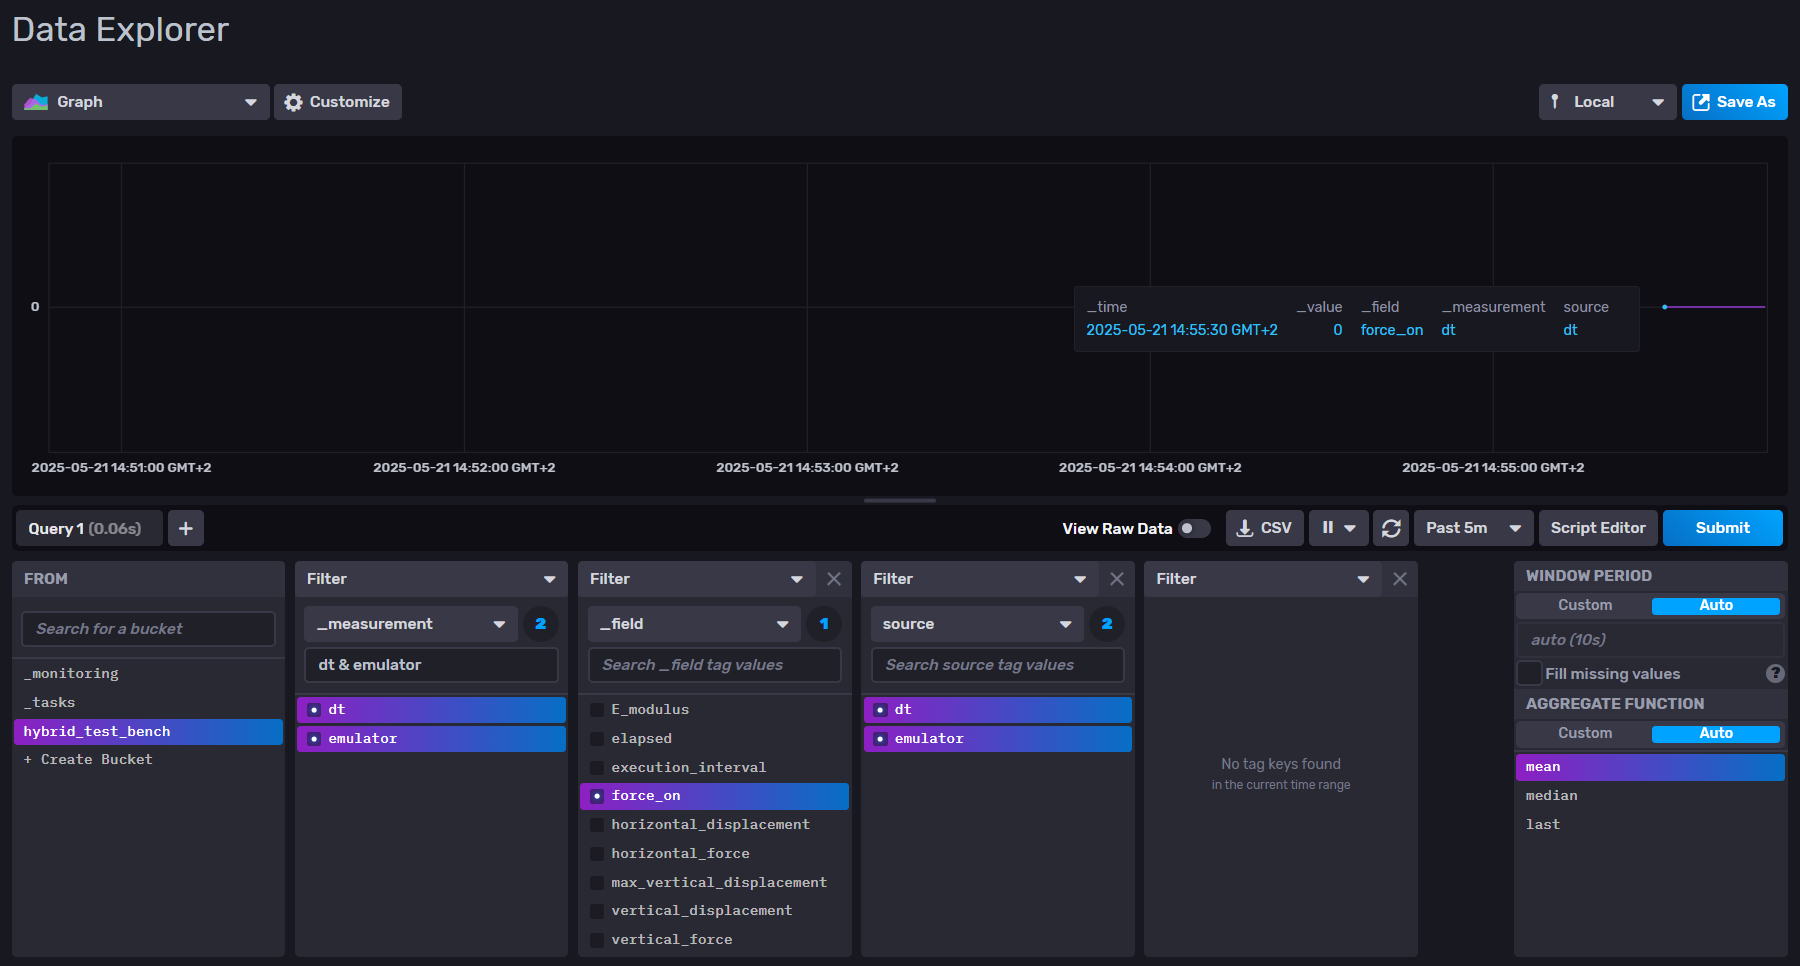

Next, we send the 'apply force' command, adjust the displacement, and modify the frequencies. We send this to the Physical Twin emulator and the DT service as well!

In [13]:
import time
from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_FORCES, ROUTING_KEY_DT_FORCES

from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": True,
                                               "horizontal_force": 100, 
                                               "vertical_displacement": 20,
                                               "horizontal_period": 2.0,
                                               "vertical_period": 2.0})

# Send a message to the DT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_DT_FORCES, {"forces": True,
                                               "horizontal_force": 100, 
                                               "vertical_displacement": 20,
                                               "horizontal_period": 2.0,
                                               "vertical_period": 2.0})

# Wait a bit for the message to be processed
time.sleep(5)

After waiting a few minutes we can see the following changes in the dashboard:

To-do: Add image of dashboard

That's it for now.

We can turn off the force application for the PT emulator:

In [33]:
# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": False})

# Wait a bit for the message to be processed
time.sleep(5)

And turn off the force application for the DT service:

In [34]:
# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_DT_FORCES, {"forces": False})

# Wait a bit for the message to be processed
time.sleep(5)

As we can see in the dashboard, the force applications are reset:

![Screenshot 2025-05-21 150927.png](<attachment:Screenshot 2025-05-21 150927.png>)
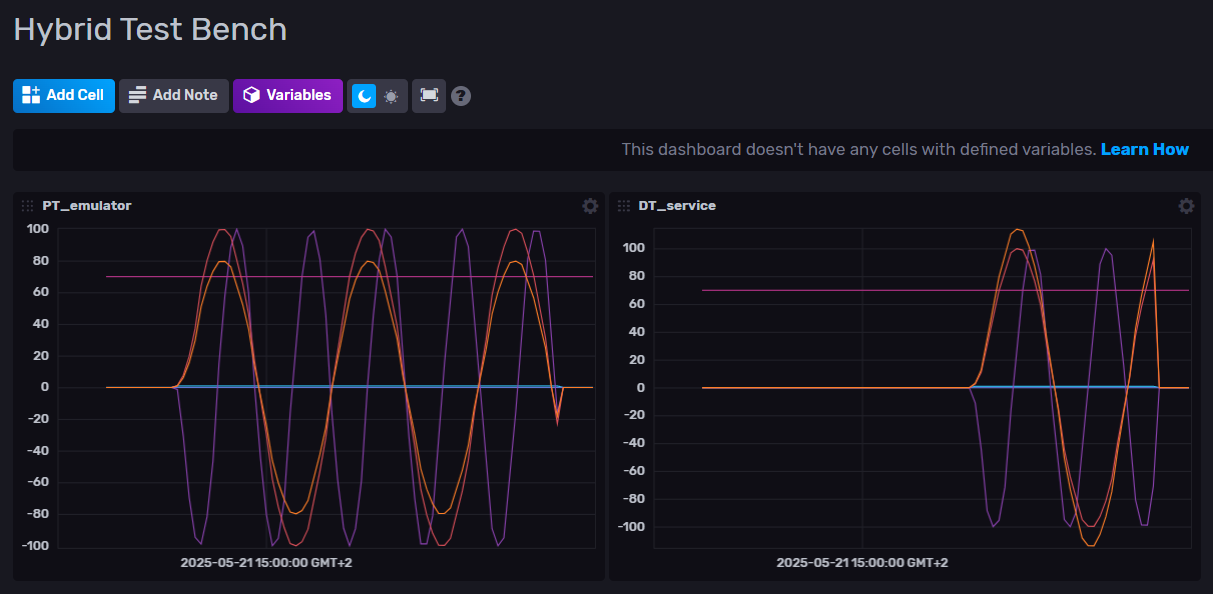

In this last step we kill all the processes:

In [35]:
pt_emulator_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
pt_emulator_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert pt_emulator_service_proc.returncode is not None, 'Process has not exited'

In [36]:
dt_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
dt_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert dt_service_proc.returncode is not None, 'Process has not exited'

In [37]:
hybrid_test_bench_data_recorder_influx_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
hybrid_test_bench_data_recorder_influx_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert hybrid_test_bench_data_recorder_influx_proc.returncode is not None, 'Process has not exited'

# 2. Rainflow-counting Algorithm

RainFlow Cycle Algorithm is implemented below:

2025-05-25 21:28:01.662 DEBUG matplotlib : matplotlib data path: c:\Users\Jonas Terpager\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\mpl-data
2025-05-25 21:28:01.675 DEBUG matplotlib : CONFIGDIR=C:\Users\Jonas Terpager\.matplotlib
2025-05-25 21:28:01.704 DEBUG matplotlib : interactive is False
2025-05-25 21:28:01.704 DEBUG matplotlib : platform is win32
2025-05-25 21:28:01.767 DEBUG matplotlib : CACHEDIR=C:\Users\Jonas Terpager\.matplotlib
2025-05-25 21:28:01.776 DEBUG matplotlib.font_manager : Using fontManager instance from C:\Users\Jonas Terpager\.matplotlib\fontlist-v390.json
[[2, 16, -14, 15, 1], [11, 16, 15, -4, -1], [12, 16, -4, 13, 1], [15, 16, 13, 0, -1], [16, 16, 0, 0]]
[[1, 3, 2, -14, -1], [2, 16, -14, 15, 1], [3, 5, 10, 0, -1], [4, 5, 0, 10, 1], [5, 11, 13, -9, -1], [6, 11, -9, 13, 1], [7, 10, 11, -9, -1], [8, 10, -8, 8, 1], [9, 10, 8, -8, -1], [10, 11, -9, 11, 1], [11, 16, 15, -4, -1], [12, 16, -4, 13, 1], [13, 15, 10, 0, -1], [14, 15, 0, 10, 1], [

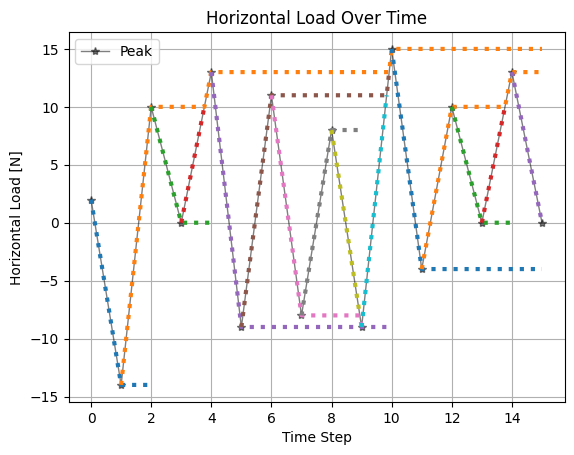

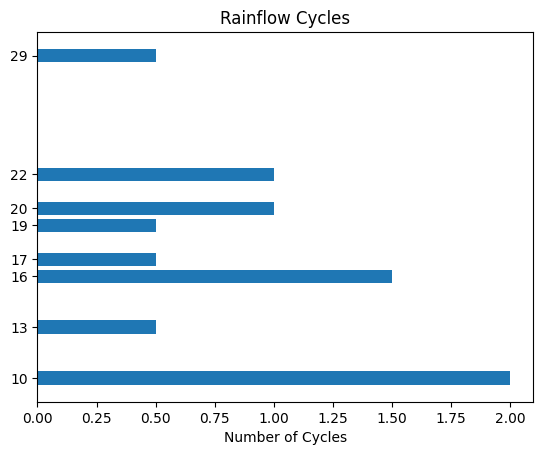

In [38]:
import RainFlowCycleAlgorithm as RFCA
import matplotlib.pyplot as plt

plt.set_loglevel(level='error')

peaks = [2, -14, 10, 0, 13, -9, 11, -8, 8, -9, 15, -4, 10, 0, 13, 0]
# peaks = [0, 100, -100, 100, -100]
# Create an instance of the RFCA class and run the counter

rfca = RFCA.RFCA(peaks)
rfca.rerun_counter()
print(rfca.get_active_flows())
print(rfca.get_flows())

# Output: list of (range, mean, count) tuples
cycles = rfca.get_cycles()
print(cycles)

print(sum([cycle[1] for cycle in cycles]))

rfca.plot_flows()
rfca.plot_cycles()